The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

def camera_calibration(link='camera_cal/calibration*.jpg'):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(link)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    ret,mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)
            
def advance_procces(image):
    (b, g, r) = cv2.split(image)
    c1 = (b < 120) & (r > 140) & (g > 140)
    c2 = (b > 180) & (r > 180) & (g > 180)
    binary_1 = np.zeros_like(b)
    binary_2 = np.zeros_like(b)
    binary_1[c1]=1
    binary_2[c2]=1
    bitwise_or = cv2.bitwise_or(binary_1, binary_2)
    return bitwise_or

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

def measure_curvature_pixels(ploty,left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    mid_imgx = img_shape[1]//2      
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    return offsetx

def annotation(img_lane, combo, leftx, rightx, ploty, left_fit, right_fit):
    left_curverad,right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
    # Display curvature_rad 
    cv2.putText(img_lane, 'curvature: {:.2f} m'.format(left_curverad), (300, 60), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    #cv2.putText(out_img, 'Right curvature: {:.2f} m'.format(right_curverad), (300, 110), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    # Display car offset
    offset = car_offset(leftx, rightx, img_lane.shape)
    cv2.putText(img_lane, 'Offset w.r.t center: {:.2f} m'.format(offset), (300, 160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    
def draw_lane(img, warp, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    reverse_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, reverse_warp, 0.3, 0)

In [3]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 3

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    delta = rightx_base-leftx_base

    return leftx, lefty, rightx, righty, delta, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty, delta):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    x = np.append(leftx, rightx-delta, axis=0)
    y = np.append(lefty, righty, axis=0)
    left_fit = np.polyfit(y, x, 2)
    right_fit = np.polyfit(y, x, 2)
    right_fit[2]=right_fit[2]+delta

    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, out_img, delta):
    # Find our lane pixels first
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    x = np.append(leftx, rightx-delta, axis=0)
    y = np.append(lefty, righty, axis=0)
    left_fit = np.polyfit(y, x, 2)
    right_fit = np.polyfit(y, x, 2)
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    right_fit[2]=right_fit[2]+delta
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty 

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit, delta):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, delta)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return out_img, left_fitx, right_fitx, ploty 



## 1. Camera Calibration

In [2]:
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');

## 2. Apply a Distortion Correction to Raw Images

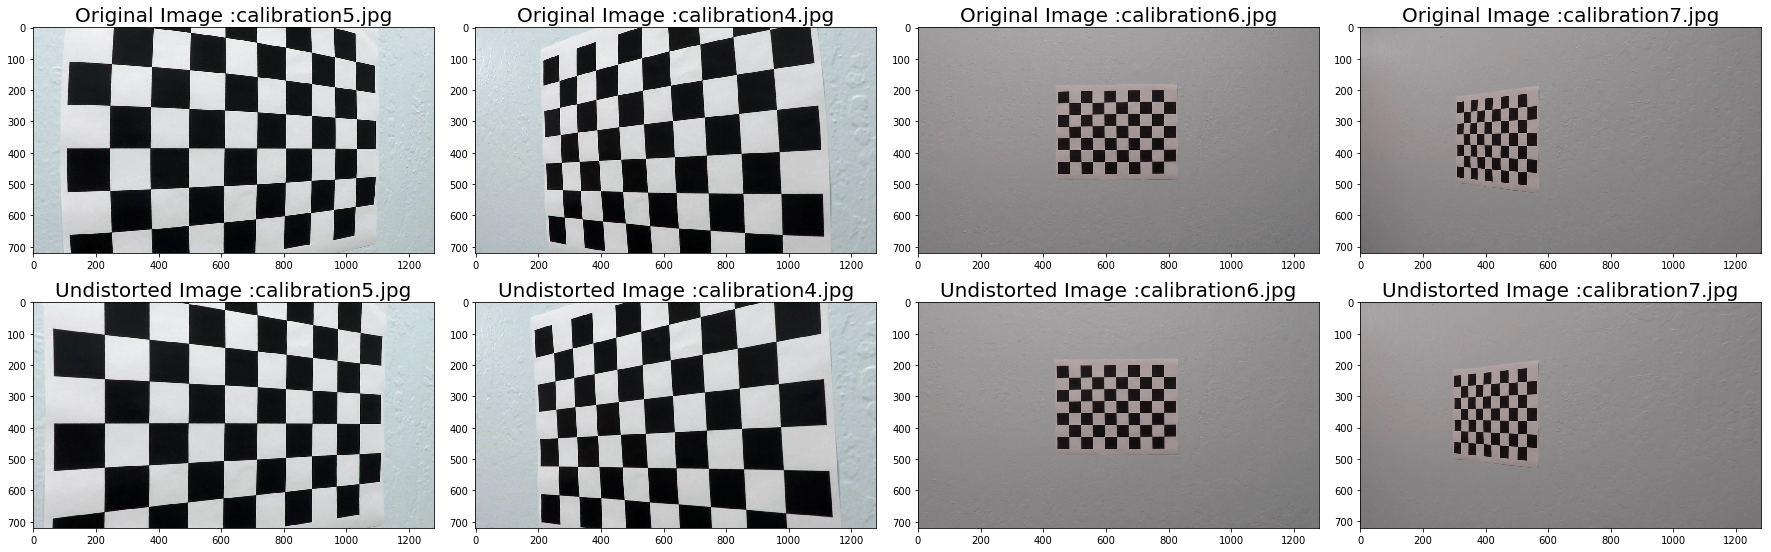

In [3]:
# cal_undistort()
f, ax = plt.subplots(2, 4, figsize=(24, 8))
cal_img_list= os.listdir("camera_cal/")
#img1 = cv2.imread('camera_cal/calibration2.jpg')
#img2 = cv2.imread('camera_cal/calibration4.jpg',cv2.COLOR_BGR2RGB)
for i in range(0,4):
    img_name = cal_img_list[i]
    img = cv2.imread("camera_cal/" + img_name, cv2.COLOR_BGR2RGB)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    f.tight_layout()
    ax[0,i].imshow(img)
    ax[0,i].set_title('Original Image :'+ img_name, fontsize=20)
    ax[1,i].imshow(undistorted)
    ax[1,i].set_title('Undistorted Image :' + img_name, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/undistort_output.png") # To save figure

## 3. Apply a perspective transform to rectify binary image ("birds-eye view")

In [4]:
src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right

M = cv2.getPerspectiveTransform(src, dst)
# don't try to get the straight line, it will be hard, some sort of distroetion is good for later poly-fit

### Draw the lines and Obtain M

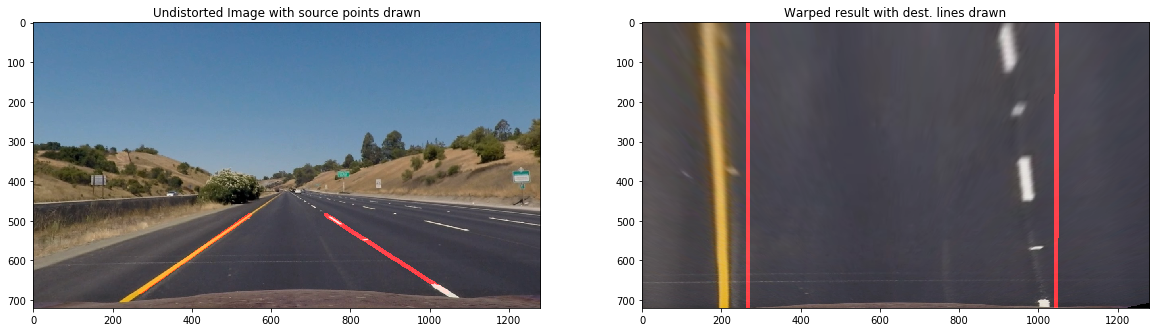

In [5]:
img2 = cv2.imread('test_images/straight_lines1.jpg',cv2.COLOR_BGR2RGB)
img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
undistorted2 = cal_undistort(img2, objpoints, imgpoints)
img_size = (undistorted2.shape[1], undistorted2.shape[0])
warped = cv2.warpPerspective(undistorted2, M, img_size)

line_image1 = np.copy(undistorted2)*0 # creating a blank to draw lines on
#lines1 = [[[274,680,546,485],[1046,680,743,485]]]
lines1 = [[[269,680,546,485],[1043,680,738,485]]]
draw_lines(line_image1, lines1, color=[255, 0, 0], thickness=10)
lines_edges1 = weighted_img(line_image1, undistorted2, 0.9, 1, 0) 

line_image2 = np.copy(undistorted2)*0 # creating a blank to draw lines on
#lines2 = [[[274,0,274,719],[1046,0,1046,719]]]
lines2 = [[[267,0,267,719],[1045,0,1043,719]]]
draw_lines(line_image2, lines2, color=[255, 0, 0], thickness=10)
lines_edges2 = weighted_img(line_image2, warped, 0.9, 1, 0) 

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image with source points drawn')
ax1.imshow(lines_edges1)

ax2.set_title('Warped result with dest. lines drawn')
ax2.imshow(lines_edges2)
plt.savefig("output_images/warped_straight_lines.jpg") 

## 4. Use Color Transforms, Gradients, etc., to create a Thresholded Binary Image

In [6]:
# this one is my magic function to detect yellow and white lanes 
def advance_procces(image):
    (b, g, r) = cv2.split(image)
    c1 = (b < 120) & (r > 140) & (g > 140)  # yellow lane, because yellow has G and B but no blue 
    c2 = (b > 180) & (r > 180) & (g > 180)  # white lane, because white has all RGB
    binary_1 = np.zeros_like(b)
    binary_2 = np.zeros_like(b)
    binary_1[c1]=1
    binary_2[c2]=1
    bitwise_or = cv2.bitwise_or(binary_1, binary_2)
    return bitwise_or

### Example of all the transformation from Step 1 to 4  

In [7]:
test_img_list= os.listdir("test_images/")
# camera_calibration()
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg'); 
#fig, ax = plt.subplots(len(test_img_list), 4, figsize=(24, 32))
#for i in range(0,len(test_img_list)):
img_name = test_img_list[3]
img = cv2.imread("test_images/" + img_name)
undistorted = cal_undistort(img, objpoints, imgpoints)
img_size = (undistorted.shape[1], undistorted.shape[0])
warped = cv2.warpPerspective(undistorted, M, img_size)
if np.mean(warped) > 100:
    background = np.ones(warped.shape, dtype="uint8") * 20
else: 
    background = np.ones(warped.shape, dtype="uint8") * 0    
subtracted_image = cv2.subtract(warped, background)
combo = advance_procces(subtracted_image)
#    fig.tight_layout()
#    ax[i,0].imshow(img)
#    ax[i,0].set_title(str(img_name), fontsize=20)
#    ax[i,1].imshow(undistorted)
#    ax[i,1].set_title('Undistorted', fontsize=20)
#    ax[i,2].imshow(warped)
#    ax[i,2].set_title('warped', fontsize=20)
#    ax[i,3].imshow(combo)
#    ax[i,3].set_title('bitwise_OR', fontsize=20)
#plt.savefig("output_images/combo_all_test_images.jpg")         

## 5. Detect lane pixels and fit to find the lane boundary. (with step 6 together)

- ### Detect the lane pixels

[234, 1058, 640]


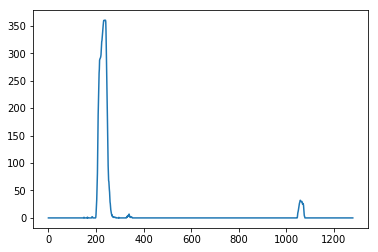

In [8]:
histogram = np.sum(combo[combo.shape[0]//2:,:], axis=0)
plt.plot(histogram)
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print([leftx_base, rightx_base, midpoint])
plt.savefig("output_images/lane_pixels.jpg")         

- ### Fit to find the lane boundary

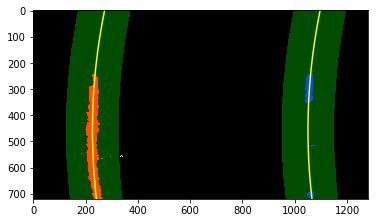

In [9]:
leftx, lefty, rightx, righty, delta, out_img = find_lane_pixels(combo)
out_img, ploty, left_fit, right_fit = fit_polynomial(combo, leftx, lefty, rightx, righty, out_img, delta)
out_img, left_fitx, right_fitx, ploty = search_around_poly(combo, left_fit, right_fit, delta)
plt.imshow(out_img)
plt.show()

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [4]:
# preparation step 1: find the objpoints, imgpoints from camera calibration
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');
# preparation step 2: identify the Perspective Transform matrix M by the given source and destination points
src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
# build the pipeline

def pipeline(img):
    t=60
    objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');
    src = np.float32(
        [[280,  700],  # Bottom left
         [595,  460],  # Top left
         [725,  460],  # Top right
         [1125, 700]]) # Bottom right

    dst = np.float32(
        [[250,  720],  # Bottom left
         [250,    0],  # Top left
         [1065,   0],  # Top right
         [1065, 720]]) # Bottom right
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
#step 1: obatin the undistort image 
    undistorted = cal_undistort(img, objpoints, imgpoints)
#step 2: apply Perspective Transform matrix M to "bird-view" 
    img_size = (undistorted.shape[1], undistorted.shape[0])
    warped = cv2.warpPerspective(undistorted, M, img_size)
#step 3: color detetion to have robust lane detetion
    if np.mean(warped) > 100:
        background = np.ones(warped.shape, dtype="uint8") * 20
    elif np.mean(warped) > 60:
        background = np.ones(warped.shape, dtype="uint8") * 0
    else: 
        background = np.ones(warped.shape, dtype="uint8") * (-20)    
    subtracted_image = cv2.subtract(warped, background)
    combo = advance_procces(subtracted_image)
    combo_size = (combo.shape[1], combo.shape[0])
    #step 4: apply the polynomial fit on histogram 
    leftx, lefty, rightx, righty, delta, out_img = find_lane_pixels(combo)
    out_img, ploty, left_fit, right_fit = fit_polynomial(combo, leftx, lefty, rightx, righty, out_img, delta)
    out_img, left_fitx, right_fitx, ploty = search_around_poly(combo, left_fit, right_fit, delta)
    #leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = find_lane_pixels(combo)
    #step 5 Warp the detected lane boundaries back onto the original image
    img_lane = draw_lane(out_img, combo, (left_fitx, ploty), (right_fitx, ploty), Minv)
    #step 6 annotate metrics onto the origianl image
    annotation(img_lane, combo, leftx, rightx, ploty, left_fit, right_fit)
    return plt.imshow(img_lane) 

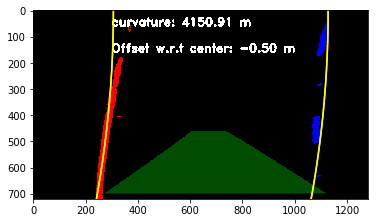

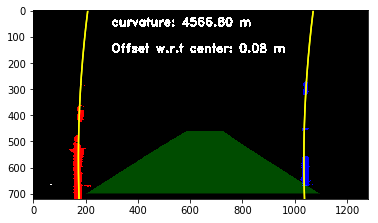

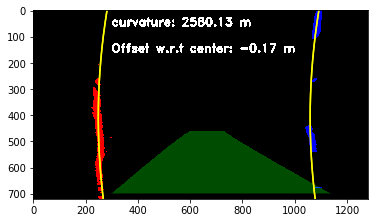

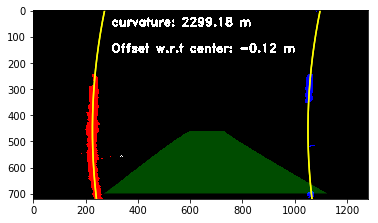

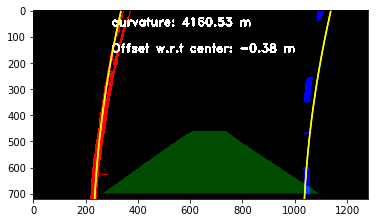

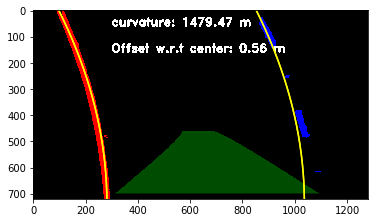

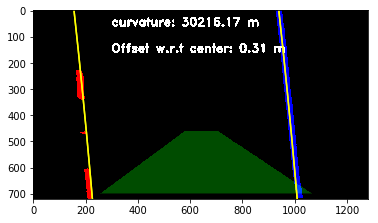

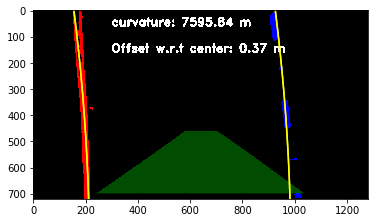

In [5]:
test_img_list= os.listdir("test_images/")
for i in range(0,len(test_img_list)):
    img_name = test_img_list[i]
    img = cv2.imread("test_images/" + img_name)
    pipeline(img)
    plt.show()

## 7. Warp the detected lane boundaries back onto the original image

## Test on Video 

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
out_dir = 'test_videos_output'
if os.path.exists(out_dir)==0:
    os.mkdir(out_dir)

IndexError: index -1 is out of bounds for axis 0 with size 0

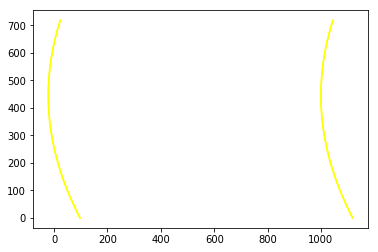

In [19]:
white_output = './test_videos_output/challenge_video_annotated.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('challenge_video.mp4').subclip(0,1)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)